#2015-07-22

##General Code:

Import Code:

In [4]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pysentani

Load survey from xlsx file and print entries and columns:

In [5]:
survey = pd.read_excel('../data-clean/sentani-merged-cleaned-2015-06-10.xlsx',na_values=[''])
print('number of entries =', len(survey))
print('number of columns =', len(survey.columns))

number of entries = 1184
number of columns = 274


Convenience function for finding column names:  pysentani.similar_columns(my_survey, 'search_term')

In [6]:
pysentani.similar_columns(survey,'fridge')

app_now/fridge
app_fridge_per_wk
app_fridge_hrs
app_fridge_use_times
app_fridge_use_times/morning
app_fridge_use_times/mid_day
app_fridge_use_times/afternoon
app_fridge_use_times/night
app_buy/fridge
app_buy_if_elec_imm/fridge
app_buy_if_elec_year/fridge
willingness_fridge


##Expenditure Data:

Combines expenditure variables to give total monthly expenditure per household:

In [7]:
survey['HP_daily'] = survey['HP_charging_price'] * survey['HP_charging_frequency'] * 52 / 365.25
survey['HP_monthly'] = survey['HP_charging_price'] * survey['HP_charging_frequency'] * 52 / 12


frequency = {'PLN_expenditure':'monthly',
     'community_microgrid_expenditure':'monthly',
     'genset_expenditure':'weekly'}

multiplier = {'monthly':1, 'weekly':4}

# create new columns with same monthly frequency
for column in frequency.keys():
    # adjust expenditure frequency
    expenditure = survey[column] * multiplier[frequency[column]]
    new_column = column + '_monthly'
    survey[new_column] = expenditure
    
temp = survey[['PLN_expenditure_monthly', 
               'community_microgrid_expenditure_monthly', 
               'genset_expenditure_monthly',
               'HP_monthly']]

# the sum function will only output NULL if all columns are NULL
survey['electricity_monthly'] = temp.sum(axis=1)

###KDE Plot:

Shows distribution of total expenditure by household. Zeros are replaced by ones to prevent errors in the log conversion:

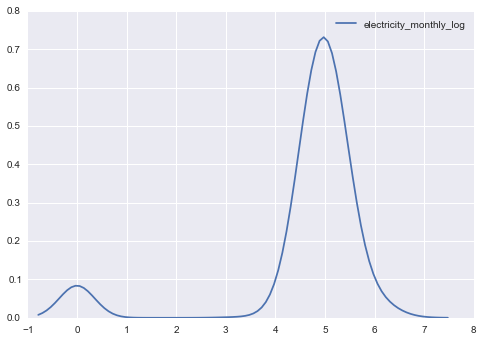

In [8]:
survey['electricity_monthly_log'] = survey['electricity_monthly'].replace(0, 1)
survey['electricity_monthly_log'] = np.log10(survey['electricity_monthly_log'])

sns.kdeplot(data=survey['electricity_monthly_log'].dropna())

Formats and displays a box plot of monthly expenditure by access type:

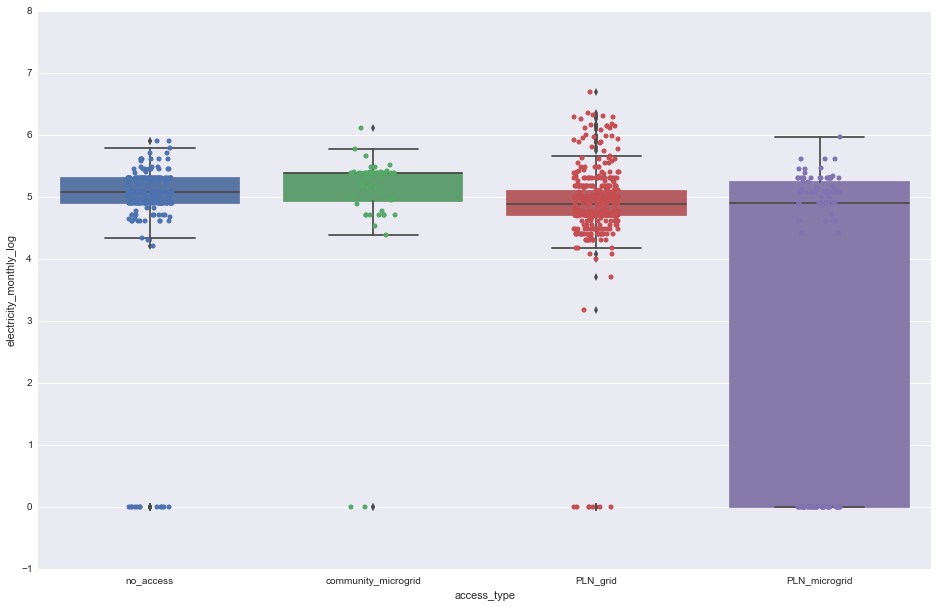

In [9]:
survey['access_type'] = pysentani.access_type(survey)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

box = sns.boxplot(x="access_type",y="electricity_monthly_log",data=survey)
jitter = sns.stripplot(x="access_type",y="electricity_monthly_log",data=survey,jitter=True,size=4)

Creates new, temporary DataFrame to hold survey data when the NULL values in electricity_monthly are removed - This is necessary because removing the NULL values creates different size columns from the original survey:

In [10]:
temp_survey = survey.dropna(subset=['electricity_monthly_log'])

Violin plot showing the expenditure data by power access_type:

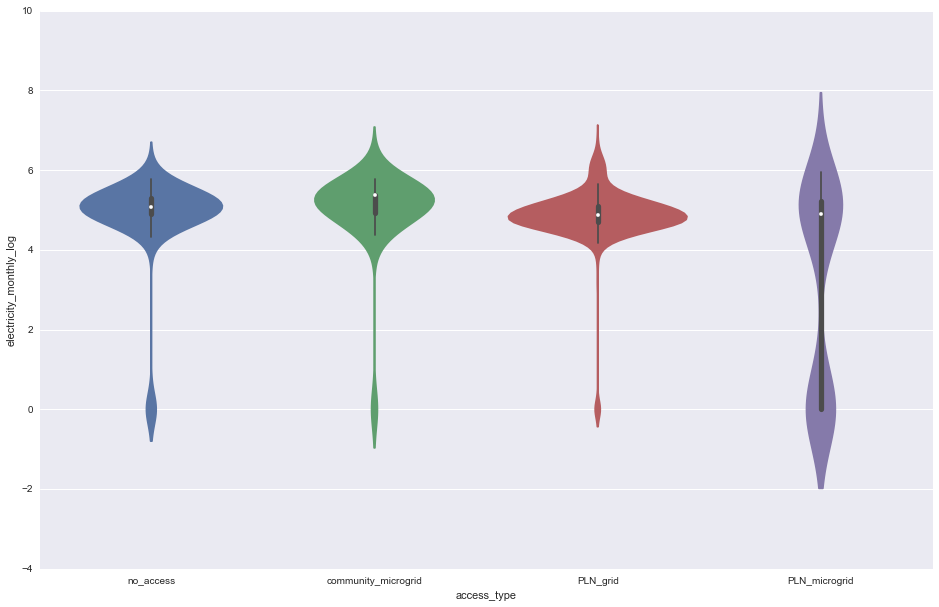

In [11]:
sns.violinplot(x="access_type",y='electricity_monthly_log',data=temp_survey)

#####Sanity Check:  Expenditure (Electricity_Monthly) should not be greater than Income (incomefreq)

###Log Scale Graph of Monthly Income vs Monthly Expenditure
(Also just a good example of how to use regplot)

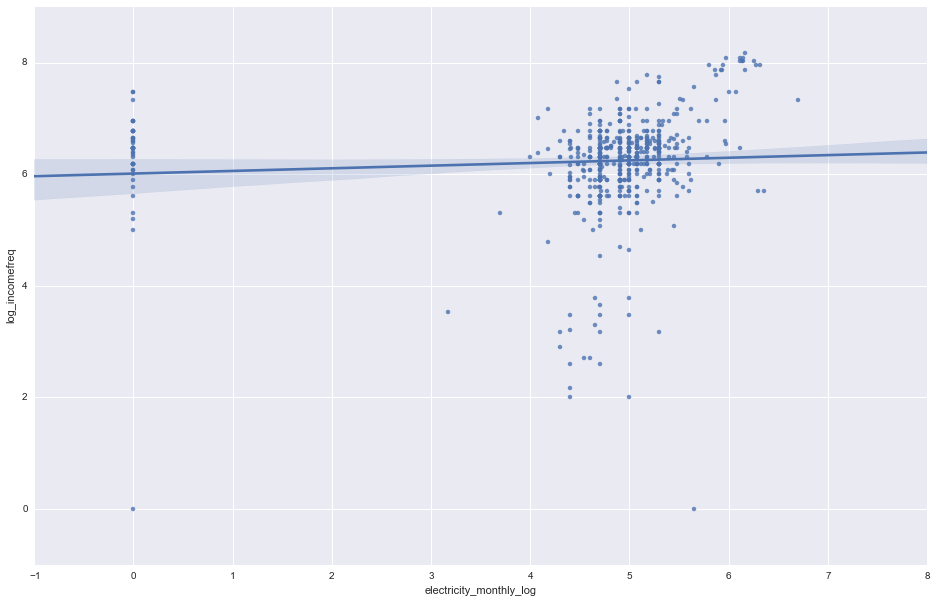

In [13]:
survey['incomefreq'] = pysentani.income_monthly(survey)
survey['access_type'] = pysentani.access_type(survey)
survey['incomefreq'] = survey['incomefreq'].replace(0, 1)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
survey['log_incomefreq'] = np.log10(survey['incomefreq'])

temp_survey = survey.dropna(subset=['electricity_monthly_log'])
sns.regplot(x= "electricity_monthly_log",y="log_incomefreq",data=temp_survey)